In [1]:
# default_exp data.eda

In [2]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
! pip install sentencepiece

     |████████████████████████████████| 1.2 MB 3.0 MB/s eta 0:00:01


# Exploratory Data Analysis 
>
>@danaderp 11.17.20 This is an exploratory data analysis for the codesearch net dataset. The goal of the exploration is to understand the code distribution of token information.
>

In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import time

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [6]:
import functools 
from operator import or_
from collections import Counter
import datetime

In [7]:
import sentencepiece as spm

In [13]:
import pickle
from pathlib import Path

In [9]:
#export
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Fixing parameters

In [15]:
#nbs_experiments/results/analyses/rnn_layers1_vocab10000_embed256_units1024
#df_buggy.to_json(path / "buggy.jsonl", orient="records", lines=True)
dvc_path = Path('../dvc-icodegen/')
def params():
    return {
        'hyper': {
            'seq_length':100,
            'batch_size':64,
            'buffer_size':10000,
            'rnn_units':1024,
            'epochs':10
        },
        'tb_01':dvc_path / 'nbs_experiments/results/analyses/rnn_layers1_vocab10000_embed256_units1024/bug_fix_error_taxonomy.jsonl',
        'tb_02':dvc_path / 'nbs_experiments/results/analyses/rnn_layers1_vocab10000_embed256_units1024/bug_fix_cross_entropy.jsonl'
    }

In [16]:
params = params()

In [18]:
#tst
logging.info( params['tb_01'] )

2021-06-22 21:34:57,053 : INFO : ../dvc-icodegen/nbs_experiments/results/analyses/rnn_layers1_vocab10000_embed256_units1024/bug_fix_error_taxonomy.jsonl


## EDA Error Ratio Analysis (by Taxonomy)
This dataset is for testing purpuses

In [19]:
df_error_tax = pd.read_json(
            params['tb_01'], orient="records", lines=True
        )

2021-06-22 21:37:07,268 : INFO : Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
2021-06-22 21:37:07,269 : INFO : Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-06-22 21:37:07,269 : INFO : NumExpr defaulting to 8 threads.


In [20]:
df_error_tax.head()

,y_blocks,y_exceptions,y_oop,y_tests,y_declarations,y_conditionals,y_loops,y_operators,y_datatypes,y_extra_tokens,code,x_treatment
0,0.0027,0.0,0.0002,0.0,0.0001,0.0000,0.0,0.0003,0.0000,0.0008,<private> <void> success<(>io.netty.channel.Ch...,False
1,0.0027,0.0,0.0002,0.0,0.0001,0.0000,0.0,0.0003,0.0000,0.0008,<private> <void> success<(>io.netty.channel.Ch...,True
2,0.0027,0.0,0.0001,0.0,0.0001,0.0001,0.0,0.0002,0.0000,0.0012,<private> <void> handleConnectRequest<(>com.as...,False
3,0.0027,0.0,0.0001,0.0,0.0001,0.0001,0.0,0.0002,0.0000,0.0012,<private> <void> handleConnectRequest<(>com.as...,True
4,0.0018,0.0,0.0002,0.0,0.0001,0.0000,0.0,0.0006,0.0004,0.0009,<@>java.lang.Override<n><protected> <void> onS...,False


In [34]:
potential_outcomes = ['y_blocks','y_exceptions','y_oop','y_tests','y_declarations','y_conditionals','y_loops','y_operators','y_datatypes','y_extra_tokens']

array([[<AxesSubplot:title={'center':'y_blocks'}>,
        <AxesSubplot:title={'center':'y_exceptions'}>],
       [<AxesSubplot:title={'center':'y_oop'}>,
        <AxesSubplot:title={'center':'y_tests'}>],
       [<AxesSubplot:title={'center':'y_declarations'}>,
        <AxesSubplot:title={'center':'y_conditionals'}>],
       [<AxesSubplot:title={'center':'y_loops'}>,
        <AxesSubplot:title={'center':'y_operators'}>],
       [<AxesSubplot:title={'center':'y_datatypes'}>,
        <AxesSubplot:title={'center':'y_extra_tokens'}>]], dtype=object)

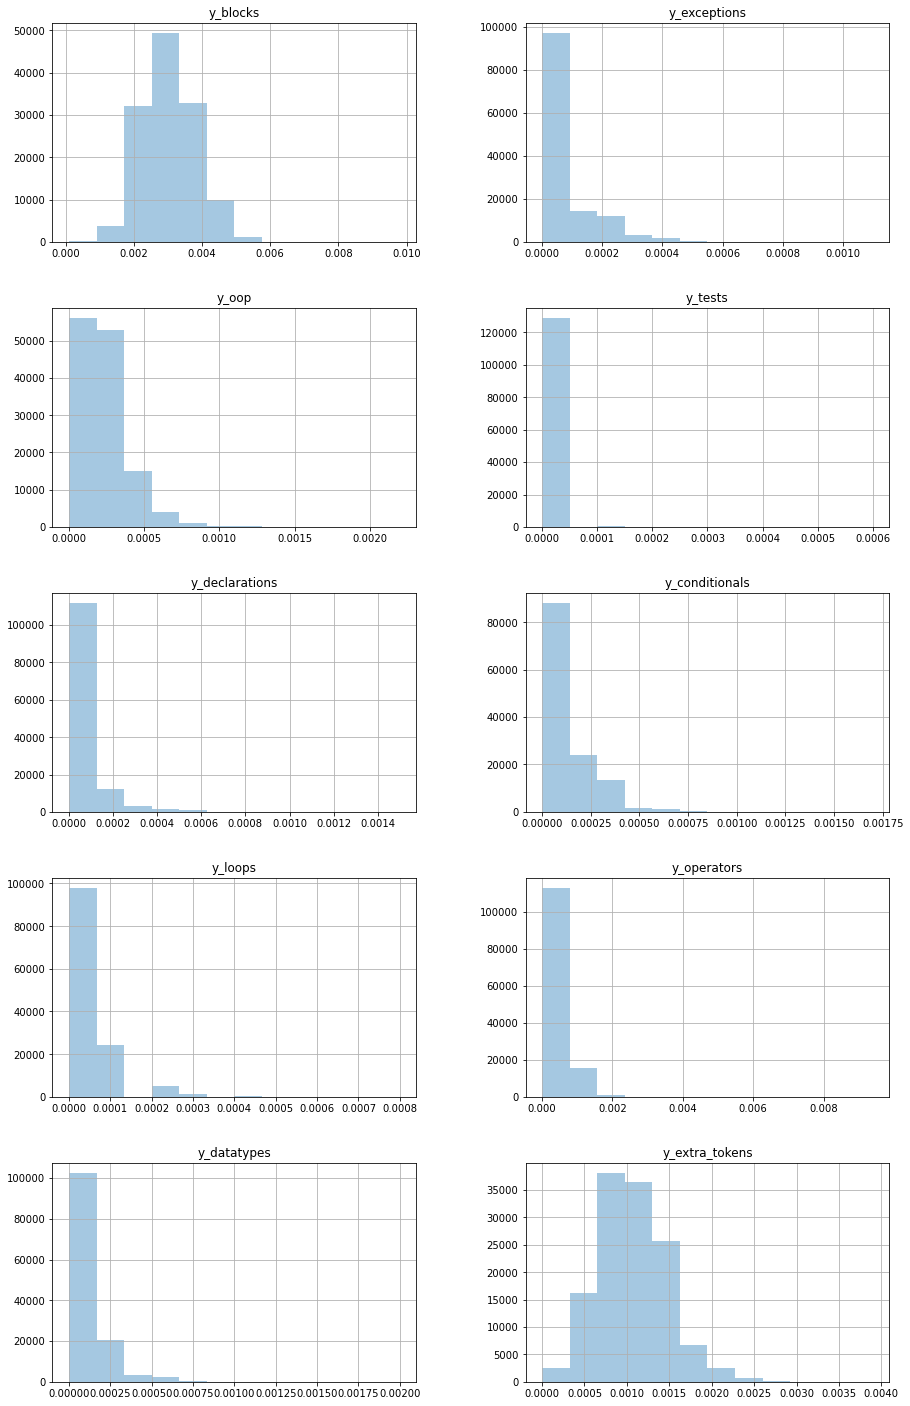

In [39]:
df_error_tax[potential_outcomes].hist(bins=12, alpha=0.4, layout=(5, 2), figsize = (15,25))

<AxesSubplot:>

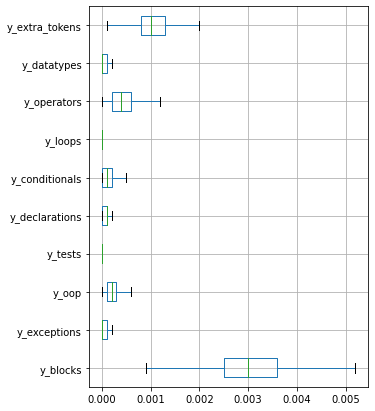

In [50]:
df_error_tax.boxplot(
    column=potential_outcomes,
    showfliers=False,
    vert=False,
    figsize=(5,7)
)

array([[<AxesSubplot:title={'center':'y_blocks'}, xlabel='x_treatment'>,
        <AxesSubplot:title={'center':'y_exceptions'}, xlabel='x_treatment'>,
        <AxesSubplot:title={'center':'y_oop'}, xlabel='x_treatment'>,
        <AxesSubplot:title={'center':'y_tests'}, xlabel='x_treatment'>,
        <AxesSubplot:title={'center':'y_declarations'}, xlabel='x_treatment'>],
       [<AxesSubplot:title={'center':'y_conditionals'}, xlabel='x_treatment'>,
        <AxesSubplot:title={'center':'y_loops'}, xlabel='x_treatment'>,
        <AxesSubplot:title={'center':'y_operators'}, xlabel='x_treatment'>,
        <AxesSubplot:title={'center':'y_datatypes'}, xlabel='x_treatment'>,
        <AxesSubplot:title={'center':'y_extra_tokens'}, xlabel='x_treatment'>]],
      dtype=object)

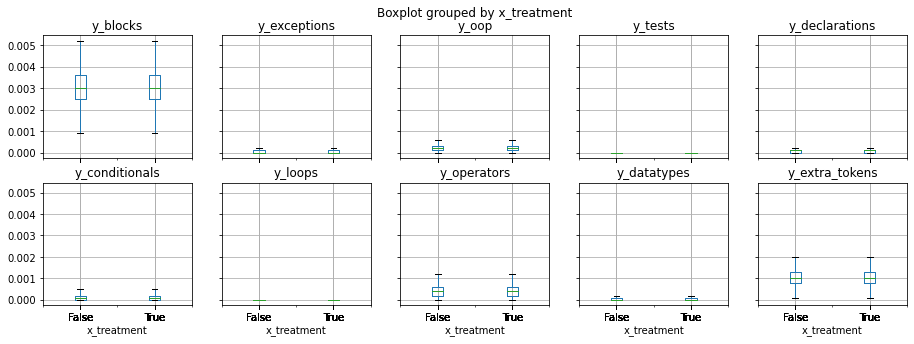

In [58]:
#Can we observe any significant difference between the error in bug and not buggy?
df_error_tax.boxplot(
    column=potential_outcomes, 
    showfliers=False, 
    #vert=False,
    layout=(2, 5), 
    figsize = (15,5),
    by="x_treatment"
)

## EDA Cross-Entropy Analysis
This dataset is for testing purpuses

In [59]:
df_cross_entr = pd.read_json(
            params['tb_02'], orient="records", lines=True
        )

In [60]:
df_cross_entr.head()

,code,y_cross_entropy,x_treatment
0,<private> <void> success<(>io.netty.channel.Ch...,6.006220,False
1,<private> <void> success<(>io.netty.channel.Ch...,6.008038,True
2,<private> <void> handleConnectRequest<(>com.as...,6.368741,False
3,<private> <void> handleConnectRequest<(>com.as...,6.337473,True
4,<@>java.lang.Override<n><protected> <void> onS...,3.927699,False


<AxesSubplot:>

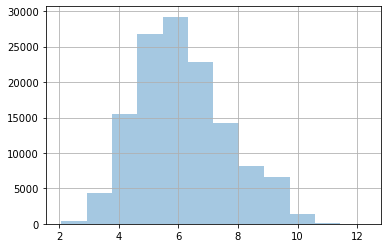

In [63]:
df_cross_entr['y_cross_entropy'].hist(
    bins=12, 
    alpha=0.4
)

<AxesSubplot:>

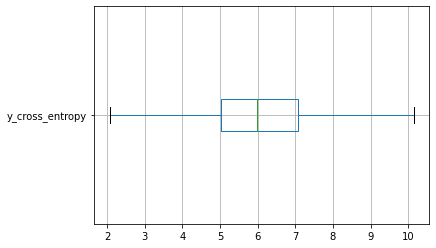

In [64]:
df_cross_entr.boxplot(
    column='y_cross_entropy',
    showfliers=False,
    vert=False,
    #figsize=(5,7)
)

<AxesSubplot:title={'center':'y_cross_entropy'}, xlabel='x_treatment'>

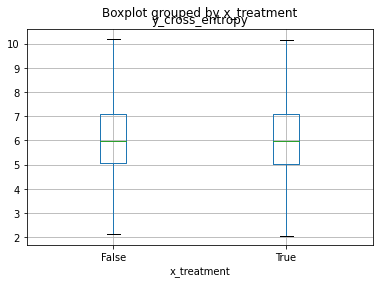

In [65]:
df_cross_entr.boxplot(
    column='y_cross_entropy',
    showfliers=False,
    by="x_treatment"
    #figsize=(5,7)
)

# First Covariate Analysis: Token Size

In [22]:
code = df_error_tax['code']

In [23]:
code[0]

'<private> <void> success<(>io.netty.channel.Channel channel<)> <{><n>    org.mycat.netty.mysql.MySQLHandshakeHandler.logger.debug<(>"success info <return> <for>m MySQLHandshakeHandler"<)><;><n>    io.netty.buffer.ByteBuf out <=> channel.alloc<(><)>.buffer<(><)><;><n>    org.mycat.netty.mysql.OK ok <=> <new> org.mycat.netty.mysql.OK<(><)><;><n>    ok.sequenceId <=> 2<;><n>    ok.setStatusFlag<(>Flags.SERVER_STATUS_AUTOCOMMIT<)><;><n>    out.writeBytes<(>ok.toPacket<(><)><)><;><n>    channel.writeAndFlush<(>out<)><;><n><}>'

# Second Covariate Analysis: SE Metrics
> This module provides a tool for computing metrics (from static analysis) for python source code using Using <a href="https://github.com/mauricioaniche/ck">CK Package</a>

CK is a java package (jar) which is going to be executed from terminal. It requires the code which is going to be analyzed to be located at <i>physical</i> files. For that reason, the dataset is going to be used to produce some <i>.java</i> files.

Each record, corresponds to a individual class. When working with method-level snippets, "articial" classes are created for performing the analysis.

In [ ]:
# export
def write_dataset_to_files(df_series, destination_path):
    """
    Function to generate .java files.
    
    Params:
    # df_series: Pandas Series (DataFrame column) with the source code records.
    # destination_path: (str) Absolute path to be used as directory for the generated files.
    
    Returns:
    
    Collection of paths for the corresponding java files.
    
    """
    java_template = 'public class <class_name>{\n    <code_snippet>\n}'
    
    if not os.path.exists(destination_path):
        logging.info('Creating directory.')
        os.mkdir(destination_path)
    
    logging.info("Generating physical .java files.")
    
    file_paths = []
    for idx, value in df_series.iteritems():
        class_name = f'ClassRecord{idx}'
        code = java_template.replace('<class_name>', class_name)
        code = code.replace('<code_snippet>', value)
        file_path = f'{destination_path}/{class_name}.java'
        with open(file_path, 'w') as file:
            file.write(code)
            file_paths.append(file_path)
            
    return file_paths

In [ ]:
# export

def jarWrapper(*args):
    process = Popen(['java', '-jar']+list(args), stdout=PIPE, stderr=PIPE)
    ret = []
    while process.poll() is None:
        line = process.stdout.readline()
        if line != '' and line.endswith(b'\n'):
            ret.append(line[:-1])
    stdout, stderr = process.communicate()
    
    ret += stdout.split(b'\n')
    if stderr != '':
        ret += stderr.split(b'\n')
        
    if '' in ret:
        ret.remove('')
    return ret

In [ ]:
# export

class JavaAnalyzer():
    """
    Class get metrics f
    """
    def __init__(self, ck_jar_path):
        self.ck_jar_path = ck_jar_path
    
    def compute_metrics(self, df_series, files_destination_path):
        """
        Computes metrics for a pandas series of java source code snippets
        
        Params
        # df_series: Pandas series (df column) containing java source snippets
        # files_destination_path: Path indicating where the physical .java files are going to be created (for metrics computation)
        
        Returns:
        
        Pandas Dataframe containing metrics
        
        """
        file_paths = write_dataset_to_files(df_series, files_destination_path)
        self.__call_ck_package(files_destination_path)
        metrics_df = self.__get_metrics_df()
        self.__remove_csv_files()
        self.__remove_tmp_java_files(file_paths)
        
        return metrics_df
        
    def __call_ck_package(self, files_path):
        """
        Performs call to external .jar package.
        """
        args = [self.ck_jar_path, files_path, 'false', '0', 'True']
        result = jarWrapper(*args)
        logging.info(f'CK package produced this output:\n{result}')
        
    def __get_metrics_df(self):
        """
        Reads report files (csv) generated by the CK package.
        
        Returns:
        
        Pandas Dataframe containing appropriate metrics
        """
        class_metrics_df = pd.read_csv('class.csv')
        # method_metrics_df = pd.read_csv('method.csv')

        # merged_df = pd.merge(left = class_metrics_df, right = method_metrics_df, left_on='file', right_on='file')

        appropriate_columns = ['file','class', 'wmc', 'totalMethodsQty', 'staticMethodsQty', 'publicMethodsQty', 'privateMethodsQty',
                          'protectedMethodsQty', 'defaultMethodsQty', 'abstractMethodsQty', 'finalMethodsQty','synchronizedMethodsQty',
                          'totalFieldsQty', 'staticFieldsQty', 'publicFieldsQty', 'privateFieldsQty', 'protectedFieldsQty',
                          'defaultFieldsQty', 'visibleFieldsQty', 'finalFieldsQty', 'synchronizedFieldsQty',
                          'nosi', 'loc', 'returnQty', 'loopQty', 'comparisonsQty', 'tryCatchQty', 'parenthesizedExpsQty',
                          'stringLiteralsQty', 'numbersQty', 'assignmentsQty', 'mathOperationsQty', 'variablesQty', 'maxNestedBlocksQty',
                          'anonymousClassesQty', 'innerClassesQty', 'lambdasQty', 'uniqueWordsQty', 'modifiers']

        class_metrics_df = class_metrics_df[appropriate_columns]

        return class_metrics_df
    
    def __remove_csv_files(self):
        """
        Removes files generated by CK package.
        """
        if os.path.exists('class.csv'):
            os.remove('class.csv')
        if os.path.exists('method.csv'):
            os.remove('method.csv')
        if os.path.exists('field.csv'):
            os.remove('field.csv')
            
    def __remove_tmp_java_files(self, paths):
        """
        Removes the temporary generated java files.
        """
        for file_path in paths:
            os.remove(file_path)

In [ ]:
# General parameters for testing

def get_default_params():
    return {
    'ck_jar_path': 'ck_metrics_tool/ck-metrics.jar',
    'search_net_ds_path': '/tf/main/dvc-ds4se/code/searchnet/clean_java.csv',
    'sampling_size': 100,
    'physical_files_path': '/tf/main/nbs/test_data/test_metrics'
}

# Data Transformations 

In [ ]:
#Avg Number of Subwords 
count_subwords = [len( eval(mtd) ) for mtd in df_train['code_tokens'].values]

In [ ]:
df_train['count_tokens'] = count_subwords

In [ ]:
#BPE 

# Descriptive Statistics

All Java Set

In [ ]:
java_df.describe()

,code_len,bpe32_len
count,467203.000000,467203.000000
mean,113.079653,146.274557
std,189.121245,303.804009
min,20.000000,20.000000
25%,42.000000,50.000000
50%,67.000000,81.000000
75%,122.000000,150.000000
max,27192.000000,52975.000000


All Java Partition

In [ ]:
df_train.describe()

,code_len,bpe32_len
count,384868.000000,384868.000000
mean,113.720826,147.151002
std,194.007951,313.904001
min,20.000000,20.000000
25%,42.000000,50.000000
50%,67.000000,81.000000
75%,122.000000,151.000000
max,27192.000000,52975.000000


In [ ]:
logging.info([ p.describe() for p in list_all_partitions])

2020-11-17 12:31:54,629 : INFO : [            code_len      bpe32_len
count  384868.000000  384868.000000
mean      113.720826     147.151002
std       194.007951     313.904001
min        20.000000      20.000000
25%        42.000000      50.000000
50%        67.000000      81.000000
75%       122.000000     151.000000
max     27192.000000   52975.000000,            code_len     bpe32_len
count  14605.000000  14605.000000
mean      94.331736    120.097843
std      115.802231    171.079255
min       21.000000     21.000000
25%       39.000000     46.000000
50%       59.000000     71.000000
75%      104.000000    127.000000
max     3099.000000   5747.000000,            code_len     bpe32_len
count  25011.000000  25011.000000
mean     114.274599    148.204710
std      166.432695    245.938732
min       21.000000     22.000000
25%       43.000000     52.000000
50%       69.000000     84.000000
75%      125.000000    155.000000
max     5685.000000  10015.000000,            code_len     bpe

In [ ]:
logging.info([ stats.median_absolute_deviation(p['code_len'].values) for p in list_all_partitions])

2020-11-17 12:29:30,408 : INFO : [45.9606, 37.065, 47.4432, 44.477999999999994]


Train Partition

In [ ]:
# Frequent Characters
train_tokens = df_train.code_tokens.values

In [ ]:
train_vocab_tokens = [ eval(method)  for method in train_tokens ] #Evaluating given tokens

In [ ]:
train_counter_tokens = [ Counter(method) for method in train_vocab_tokens ] #Counting the words

In [ ]:
train_counter = functools.reduce(lambda a,b : a+b, train_counter_tokens ) ## [Warning! Time Consuming]

In [ ]:
train_counter

NameError: name 'train_counter' is not defined

In [ ]:
#Persisting the counter object
with open(params['eda']+'['+ str(datetime.datetime.now()) +']-codesearchnet_token_counts.pickle', 'wb') as outputfile:
    pickle.dump( train_counter, outputfile )